In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

from patsy import dmatrix

In [2]:
df = pd.read_csv("triceps.csv")
df

,age,lntriceps,triceps
0,12.050000,1.223776,3.4
1,9.910000,1.386294,4.0
2,10.040000,1.435084,4.2
3,11.490000,1.435084,4.2
4,10.120000,1.481605,4.4
...,...,...,...
887,27.150000,1.648659,5.2
888,7.910000,1.916923,6.8
889,7.990000,1.435084,4.2
890,14.630000,2.197225,9.0


In [3]:
def plot_scatter(df, figsize=(12, 8), height_ratios=(1, 4)):
    fig, (ax_top, ax_bottom) = plt.subplots(
        nrows=2, sharex=True, figsize=figsize, 
        gridspec_kw={"height_ratios": height_ratios}
    )
    
    df_std = df.groupby(df["age"].round())["triceps"].std().rolling(6).mean().reset_index()
    ax_top.plot(df_std["age"], df_std["triceps"])
       
    ax_bottom.scatter(df["age"], df["triceps"], s=30, alpha=0.4)
    ax_bottom.set_xlabel("Age")
    ax_bottom.set_ylabel("Triceps")
    ax_bottom.axhline(color="0.25", ls="--", lw=1.4);
    
    return fig, (ax_top, ax_bottom)

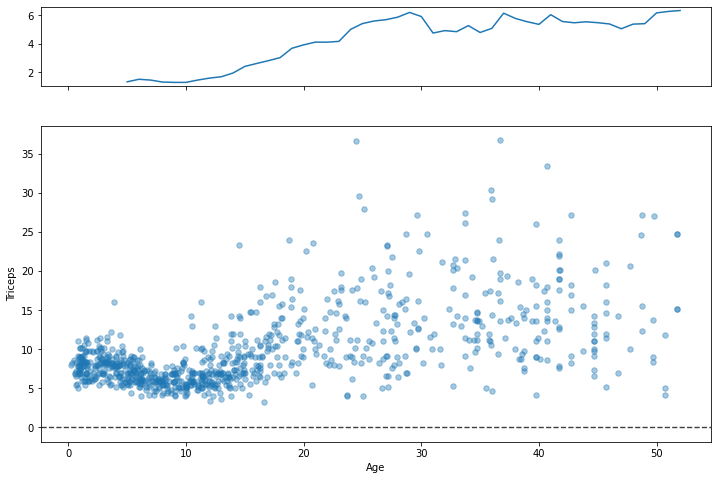

In [4]:
plot_scatter(df);

In [5]:
knots = [5, 10, 15, 20, 30, 40]
X = dmatrix("bs(age, knots=knots) - 1", df)
basis = np.asarray(X)
basis.shape

(892, 9)

In [6]:
coords = {"knot": np.arange(basis.shape[1])}

with pm.Model(coords=coords) as model:
    α = pm.Normal("α", 0., 2.5)
    β = pm.Normal("β", 0., 2., dims="knot")
    σ = pm.HalfNormal("σ", 2.)
    μ = pm.Deterministic("μ", α + tt.dot(basis, β))
    obs = pm.Normal("obs", μ, σ, observed=df["triceps"])
    
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


In [7]:
def compute_posterior_predictive(model, idata):
    with model:
        pp_trace = pm.sample_posterior_predictive(idata)
    if "posterior_predictive" in idata:
        del idata.posterior_predictive
    idata.add_groups({"posterior_predictive": {"obs": pp_trace["obs"].reshape(2, 1000, 892)}})

In [8]:
def plot_scatter_posterior(df, idata, fig, axes):
    ax_top, ax_bottom = axes
    
    idxs = list(df["age"].sort_values().index)
    mu_sorted = idata.posterior["μ"].values[..., idxs]
    pp_sorted = idata.posterior_predictive["obs"].values[..., idxs]
    age_sorted = df["age"][idxs]
    
    ax_top.plot(age_sorted, pp_sorted.std(axis=(0, 1)), color="black")

    ax_bottom.plot(age_sorted, mu_sorted.mean(axis=(0, 1)), color="black", solid_capstyle="butt")
    
    az.plot_hdi(age_sorted, mu_sorted, ax=ax_bottom, fill_kwargs={"color": "black", "alpha": 0.25})
    az.plot_hdi(age_sorted, pp_sorted, ax=ax_bottom, fill_kwargs={"color": "black", "alpha": 0.25})
    
    return fig, (ax_top, ax_bottom)

In [9]:
compute_posterior_predictive(model, idata)

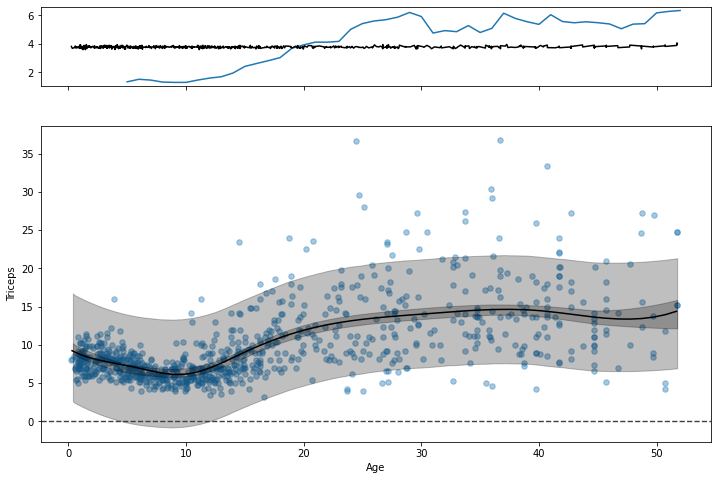

In [10]:
fig, axes = plot_scatter(df)
plot_scatter_posterior(df, idata, fig, axes);

In [11]:
with pm.Model(coords=coords) as model:
    α = pm.Normal("α", 0., 2.5)
    β = pm.Normal("β", 0., 2., dims="knot")
    μ = pm.Deterministic("μ", α + tt.dot(basis, β))
    
    α_σ = pm.Normal("α_σ", 0., 2.5)
    β_σ = pm.Normal("β_σ", 0., 2., dims="knot")
    σ = pm.Deterministic("σ", 0.05 + tt.exp(α_σ + tt.dot(basis, β_σ)))
    
    obs = pm.Normal("obs", μ, σ, observed=df["triceps"])
    idata = pm.sample(target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β_σ, α_σ, β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


In [12]:
compute_posterior_predictive(model, idata)

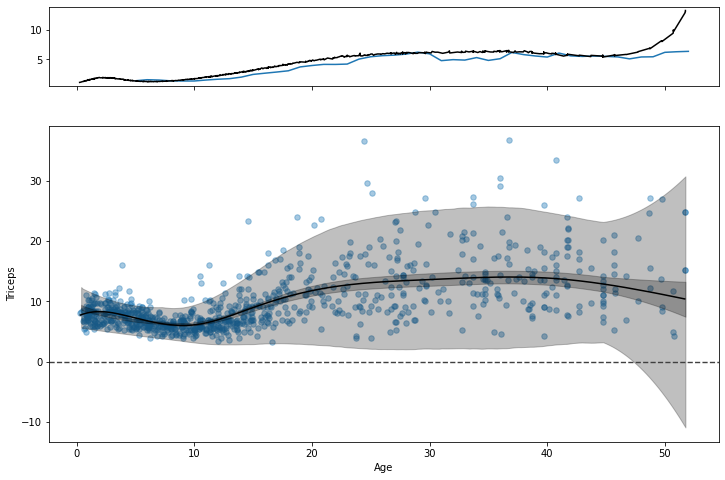

In [13]:
fig, axes = plot_scatter(df)
plot_scatter_posterior(df, idata, fig, axes);

In [14]:
X = dmatrix("cr(age, knots=knots) - 1", df)
basis = np.asarray(X)

In [15]:
coords = {"knot": np.arange(basis.shape[1])}

with pm.Model(coords=coords) as model:
    α = pm.Normal("α", 0., 2.5)
    β = pm.Normal("β", 0., 2., dims="knot")
    μ = pm.Deterministic("μ", α + tt.dot(basis, β))
    
    α_σ = pm.Normal("α_σ", 0., 2.5)
    β_σ = pm.Normal("β_σ", 0., 2., dims="knot")
    σ = pm.Deterministic("σ", 0.05 + tt.exp(α_σ + tt.dot(basis, β_σ)))
    
    obs = pm.Normal("obs", μ, σ, observed=df["triceps"])
    idata = pm.sample(target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β_σ, α_σ, β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [16]:
compute_posterior_predictive(model, idata)

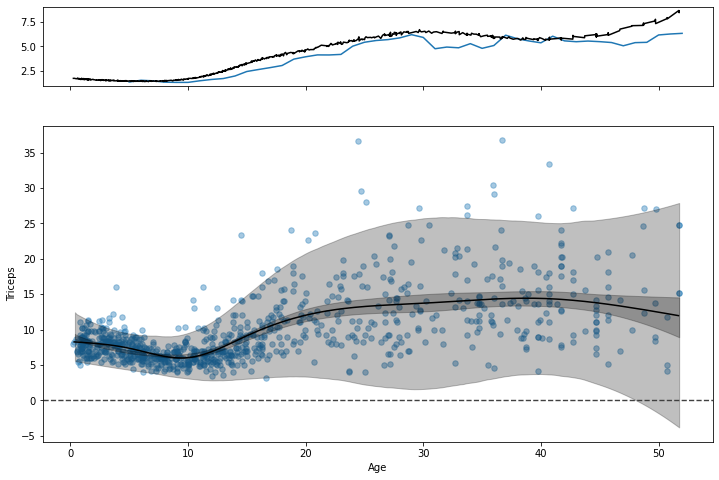

In [17]:
fig, axes = plot_scatter(df)
plot_scatter_posterior(df, idata, fig, axes);


## Gamma likelihood

In [82]:
X = dmatrix("bs(center(age), knots=knots - np.mean(age), include_intercept=False) - 1", df)
basis = np.asarray(X)

In [83]:
basis.round(3)

array([[0.   , 0.035, 0.532, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.179, 0.663, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.166, 0.664, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.017, 0.417, 0.53 , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.206, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.164, 0.   , 0.   ]])

In [84]:
basis.sum(1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [19]:
coords = {"knot": np.arange(basis.shape[1])}

with pm.Model(coords=coords) as model:
    α = pm.Normal("α", 0., 2.5)
    β = pm.Normal("β", 0., 2., dims="knot")
    μ = pm.Deterministic("μ", tt.exp(α + tt.dot(basis, β)))
    
    σ = pm.HalfStudentT("σ", nu=4, sigma=2.5)
    
    obs = pm.Gamma("obs", mu=μ, sigma=σ, observed=df["triceps"])
    idata = pm.sample(target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [20]:
compute_posterior_predictive(model, idata)

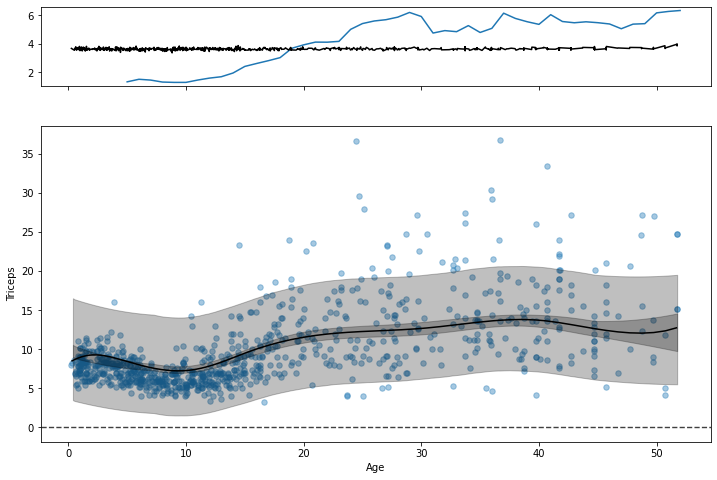

In [21]:
fig, axes = plot_scatter(df)
plot_scatter_posterior(df, idata, fig, axes);

In [22]:
coords = {"knot": np.arange(basis.shape[1])}

with pm.Model(coords=coords) as model:
    α = pm.Normal("α", 0., 2.5)
    β = pm.Normal("β", 0., 2., dims="knot")
    μ = pm.Deterministic("μ", tt.exp(α + tt.dot(basis, β)))
    
    α_σ = pm.Normal("α_σ", 0., 2.5)
    β_σ = pm.Normal("β_σ", 0., 2., dims="knot")
    σ = pm.Deterministic("σ", 0.05 + tt.exp(α_σ + tt.dot(basis, β_σ)))
    
    obs = pm.Gamma("obs", mu=μ, sigma=σ, observed=df["triceps"])
    idata = pm.sample(target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β_σ, α_σ, β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.


In [23]:
compute_posterior_predictive(model, idata)

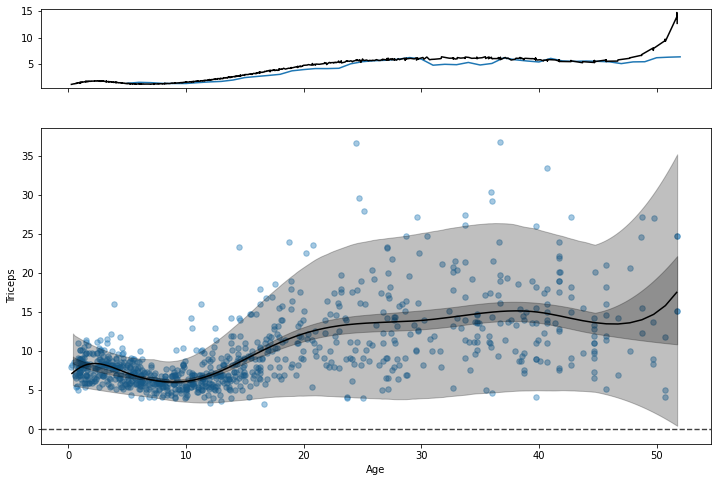

In [24]:
fig, axes = plot_scatter(df)
plot_scatter_posterior(df, idata, fig, axes);

In [56]:
# Note the center constrain!
X = dmatrix("cr(age, knots=knots, constraints='center') - 1", df)
basis = np.asarray(X)

In [60]:
coords = {"knot": np.arange(basis.shape[1])}

with pm.Model(coords=coords) as model:
    α = pm.Normal("α", 0., 2.5)
    β = pm.Normal("β", 0., 2., dims="knot")
    μ = pm.Deterministic("μ", tt.exp(α + tt.dot(basis, β)))
    
    σ = pm.HalfStudentT("σ", nu=4, sigma=2.5)
    
    obs = pm.Gamma("obs", mu=μ, sigma=σ, observed=df["triceps"])
    idata = pm.sample(target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


In [61]:
compute_posterior_predictive(model, idata)

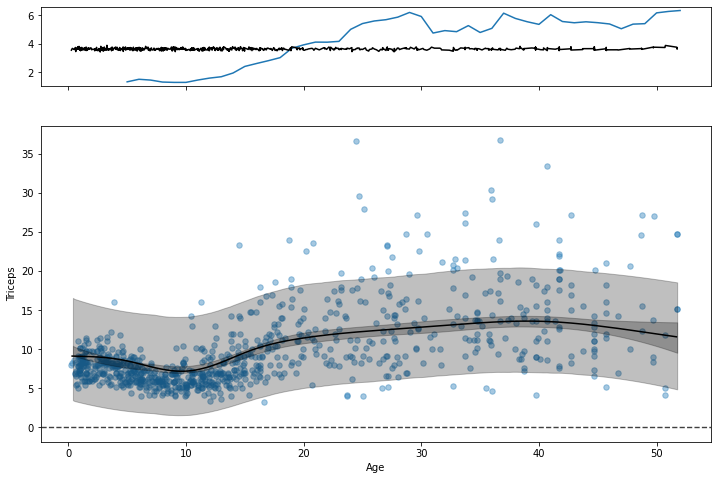

In [62]:
fig, axes = plot_scatter(df)
plot_scatter_posterior(df, idata, fig, axes);

In [63]:
coords = {"knot": np.arange(basis.shape[1])}

with pm.Model(coords=coords) as model:
    α = pm.Normal("α", 0., 2.5)
    β = pm.Normal("β", 0., 2., dims="knot")
    μ = pm.Deterministic("μ", tt.exp(α + tt.dot(basis, β)))
    
    α_σ = pm.Normal("α_σ", 0., 2.5)
    β_σ = pm.Normal("β_σ", 0., 2., dims="knot")
    σ = pm.Deterministic("σ", 0.05 + tt.exp(α_σ + tt.dot(basis, β_σ)))
    
    obs = pm.Gamma("obs", mu=μ, sigma=σ, observed=df["triceps"])
    idata = pm.sample(target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β_σ, α_σ, β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [64]:
compute_posterior_predictive(model, idata)

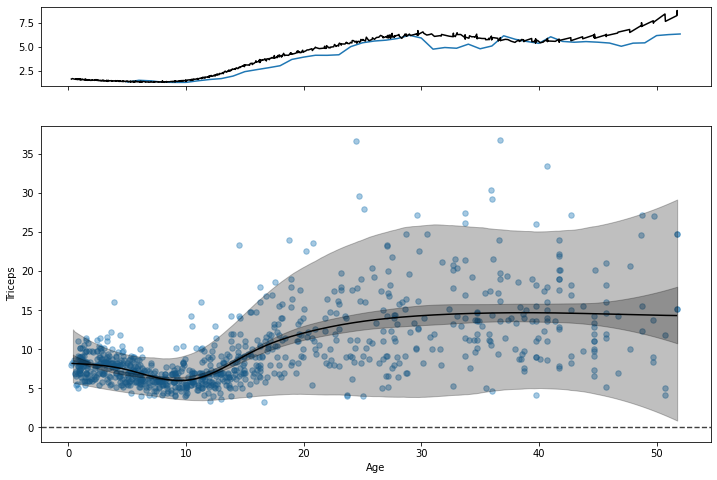

In [65]:
fig, axes = plot_scatter(df)
plot_scatter_posterior(df, idata, fig, axes);

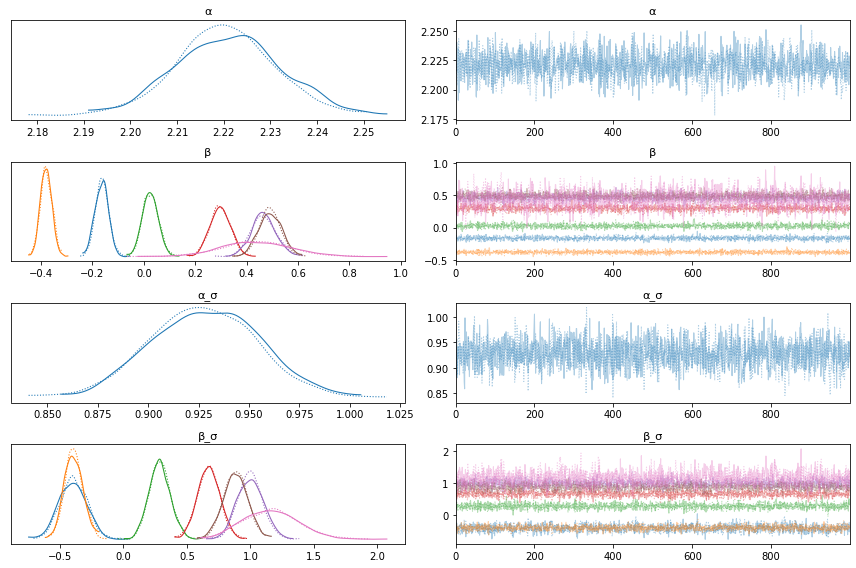

In [70]:
az.plot_trace(idata, var_names=["α", "β", "α_σ", "β_σ"]);
plt.tight_layout()

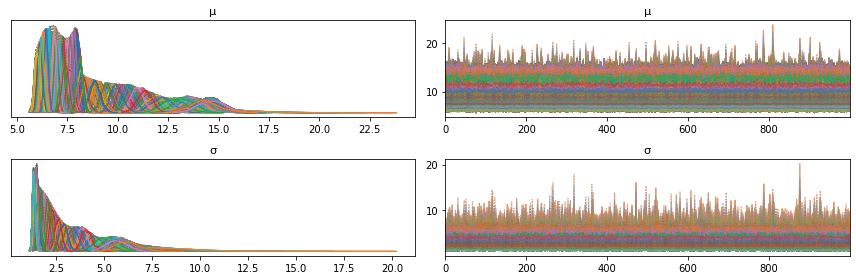

In [73]:
az.plot_trace(idata, var_names=["μ", "σ"]);
plt.tight_layout()

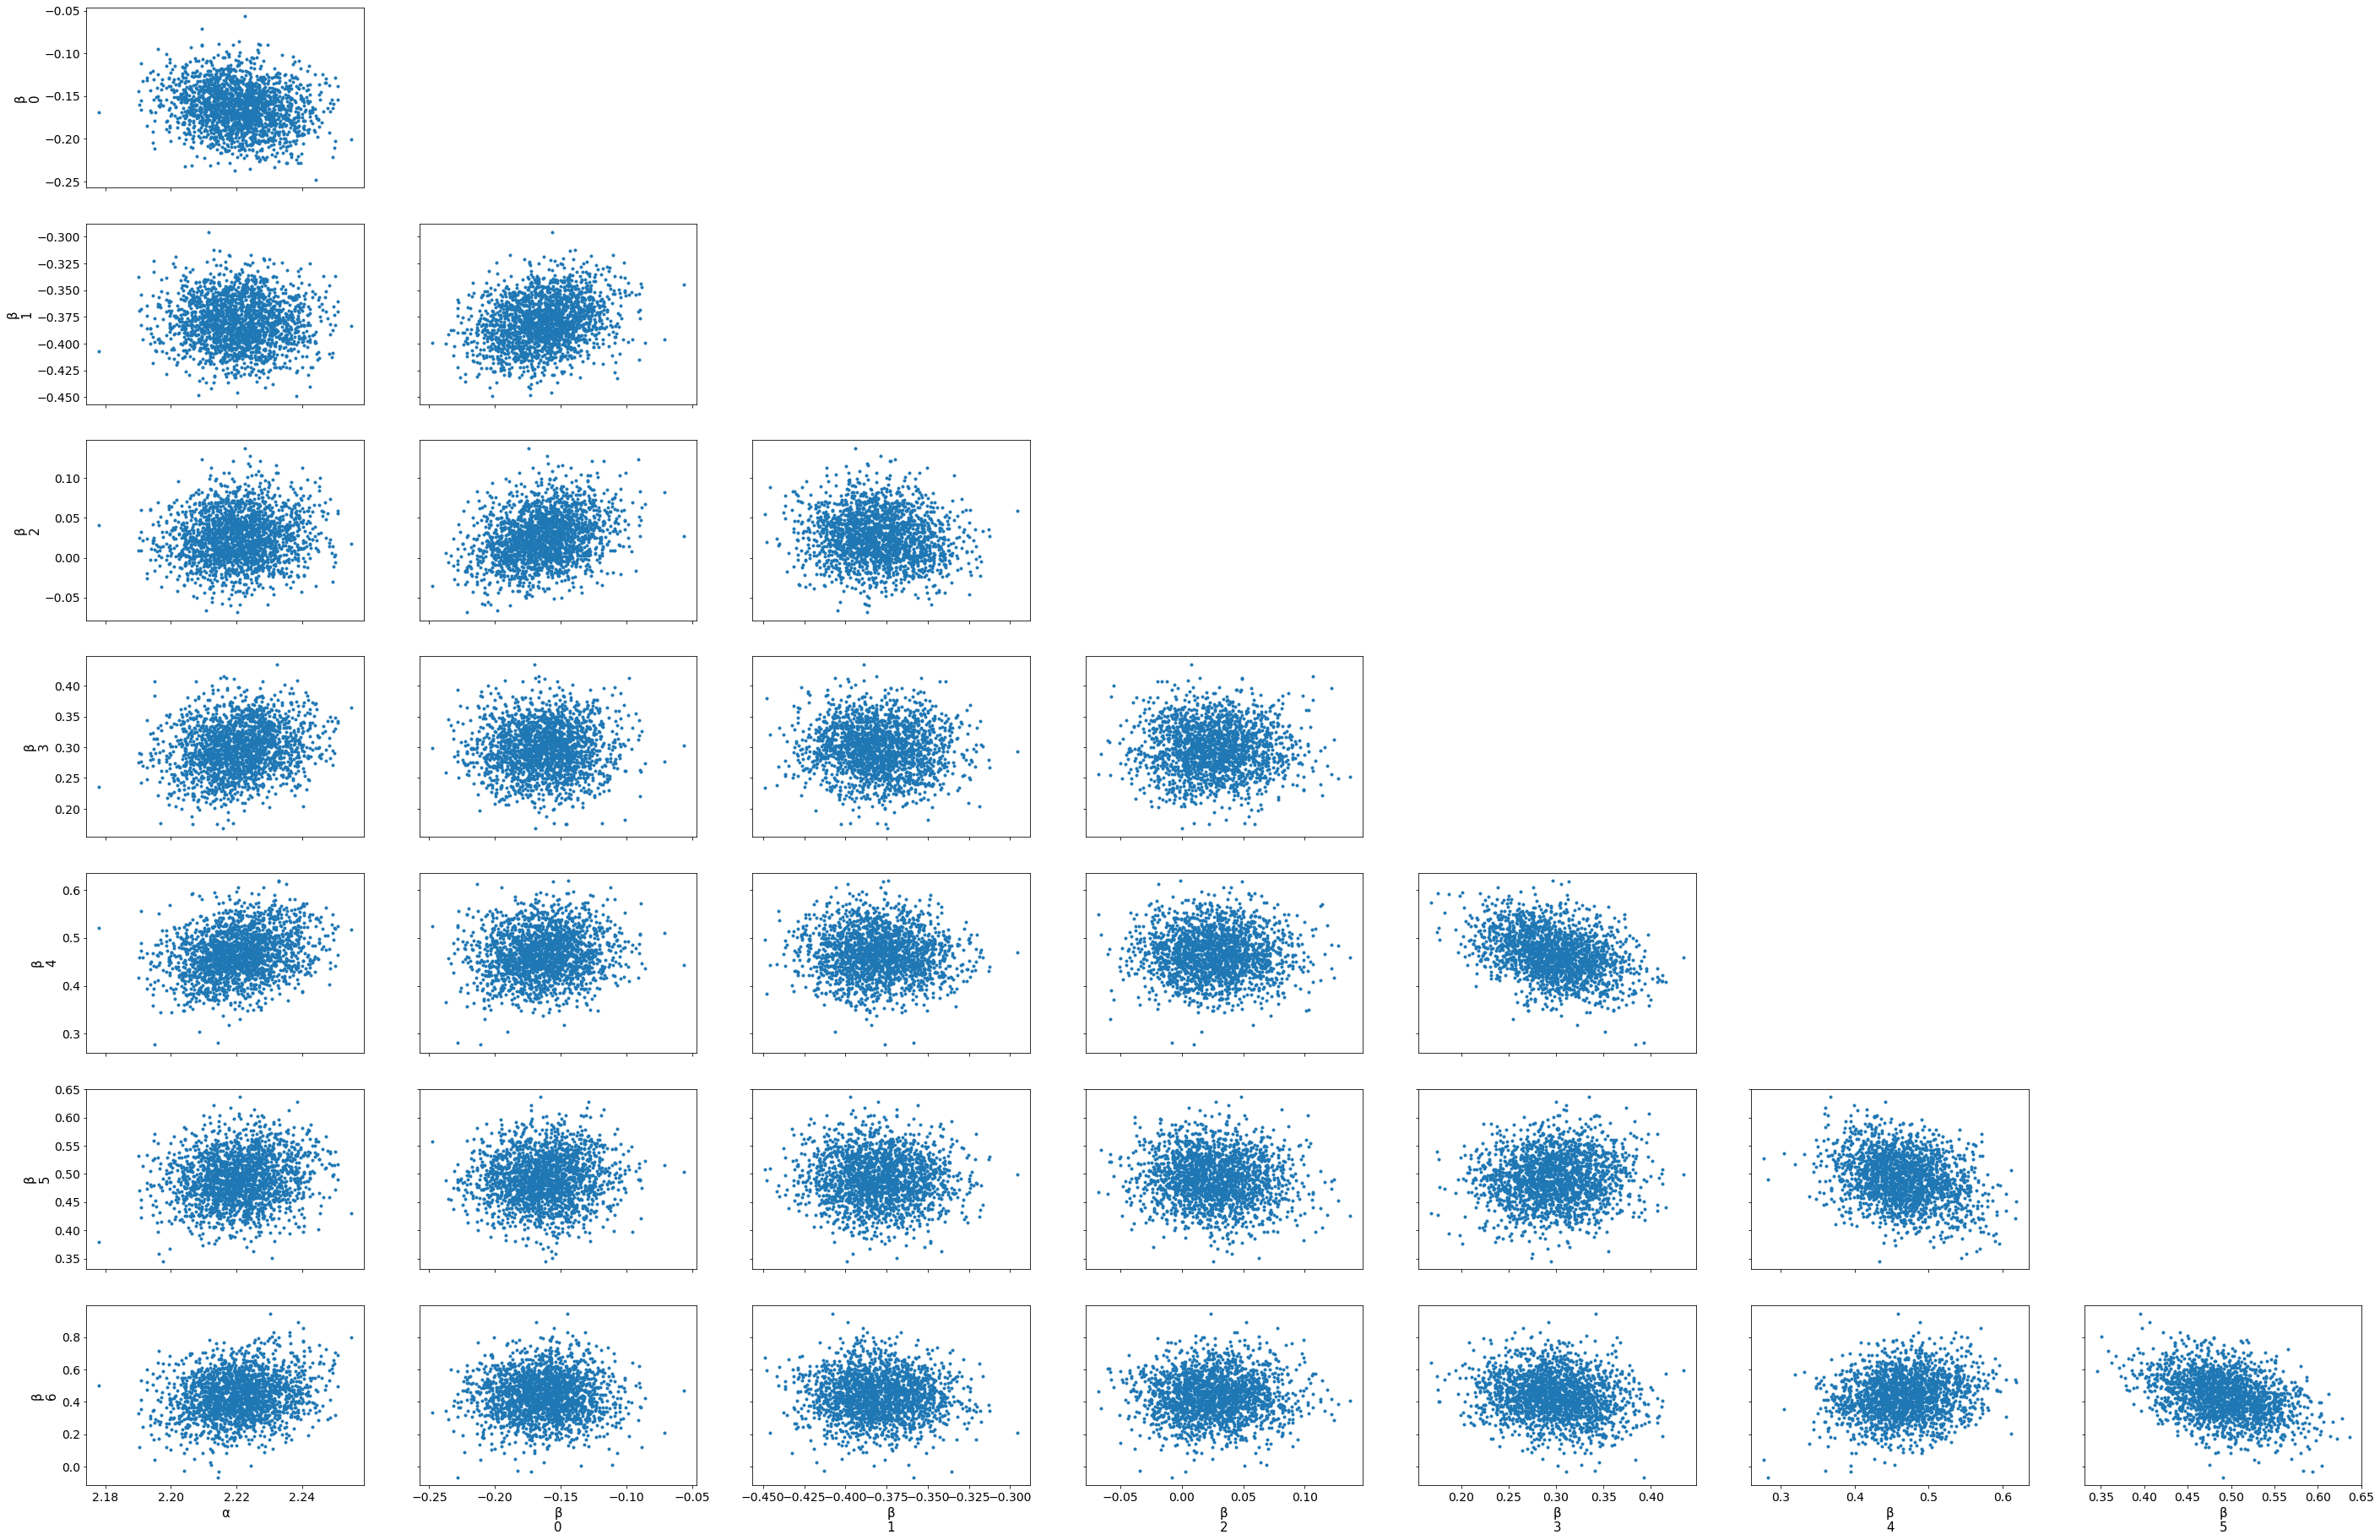

In [71]:
az.plot_pair(idata, var_names=["α", "β"]);

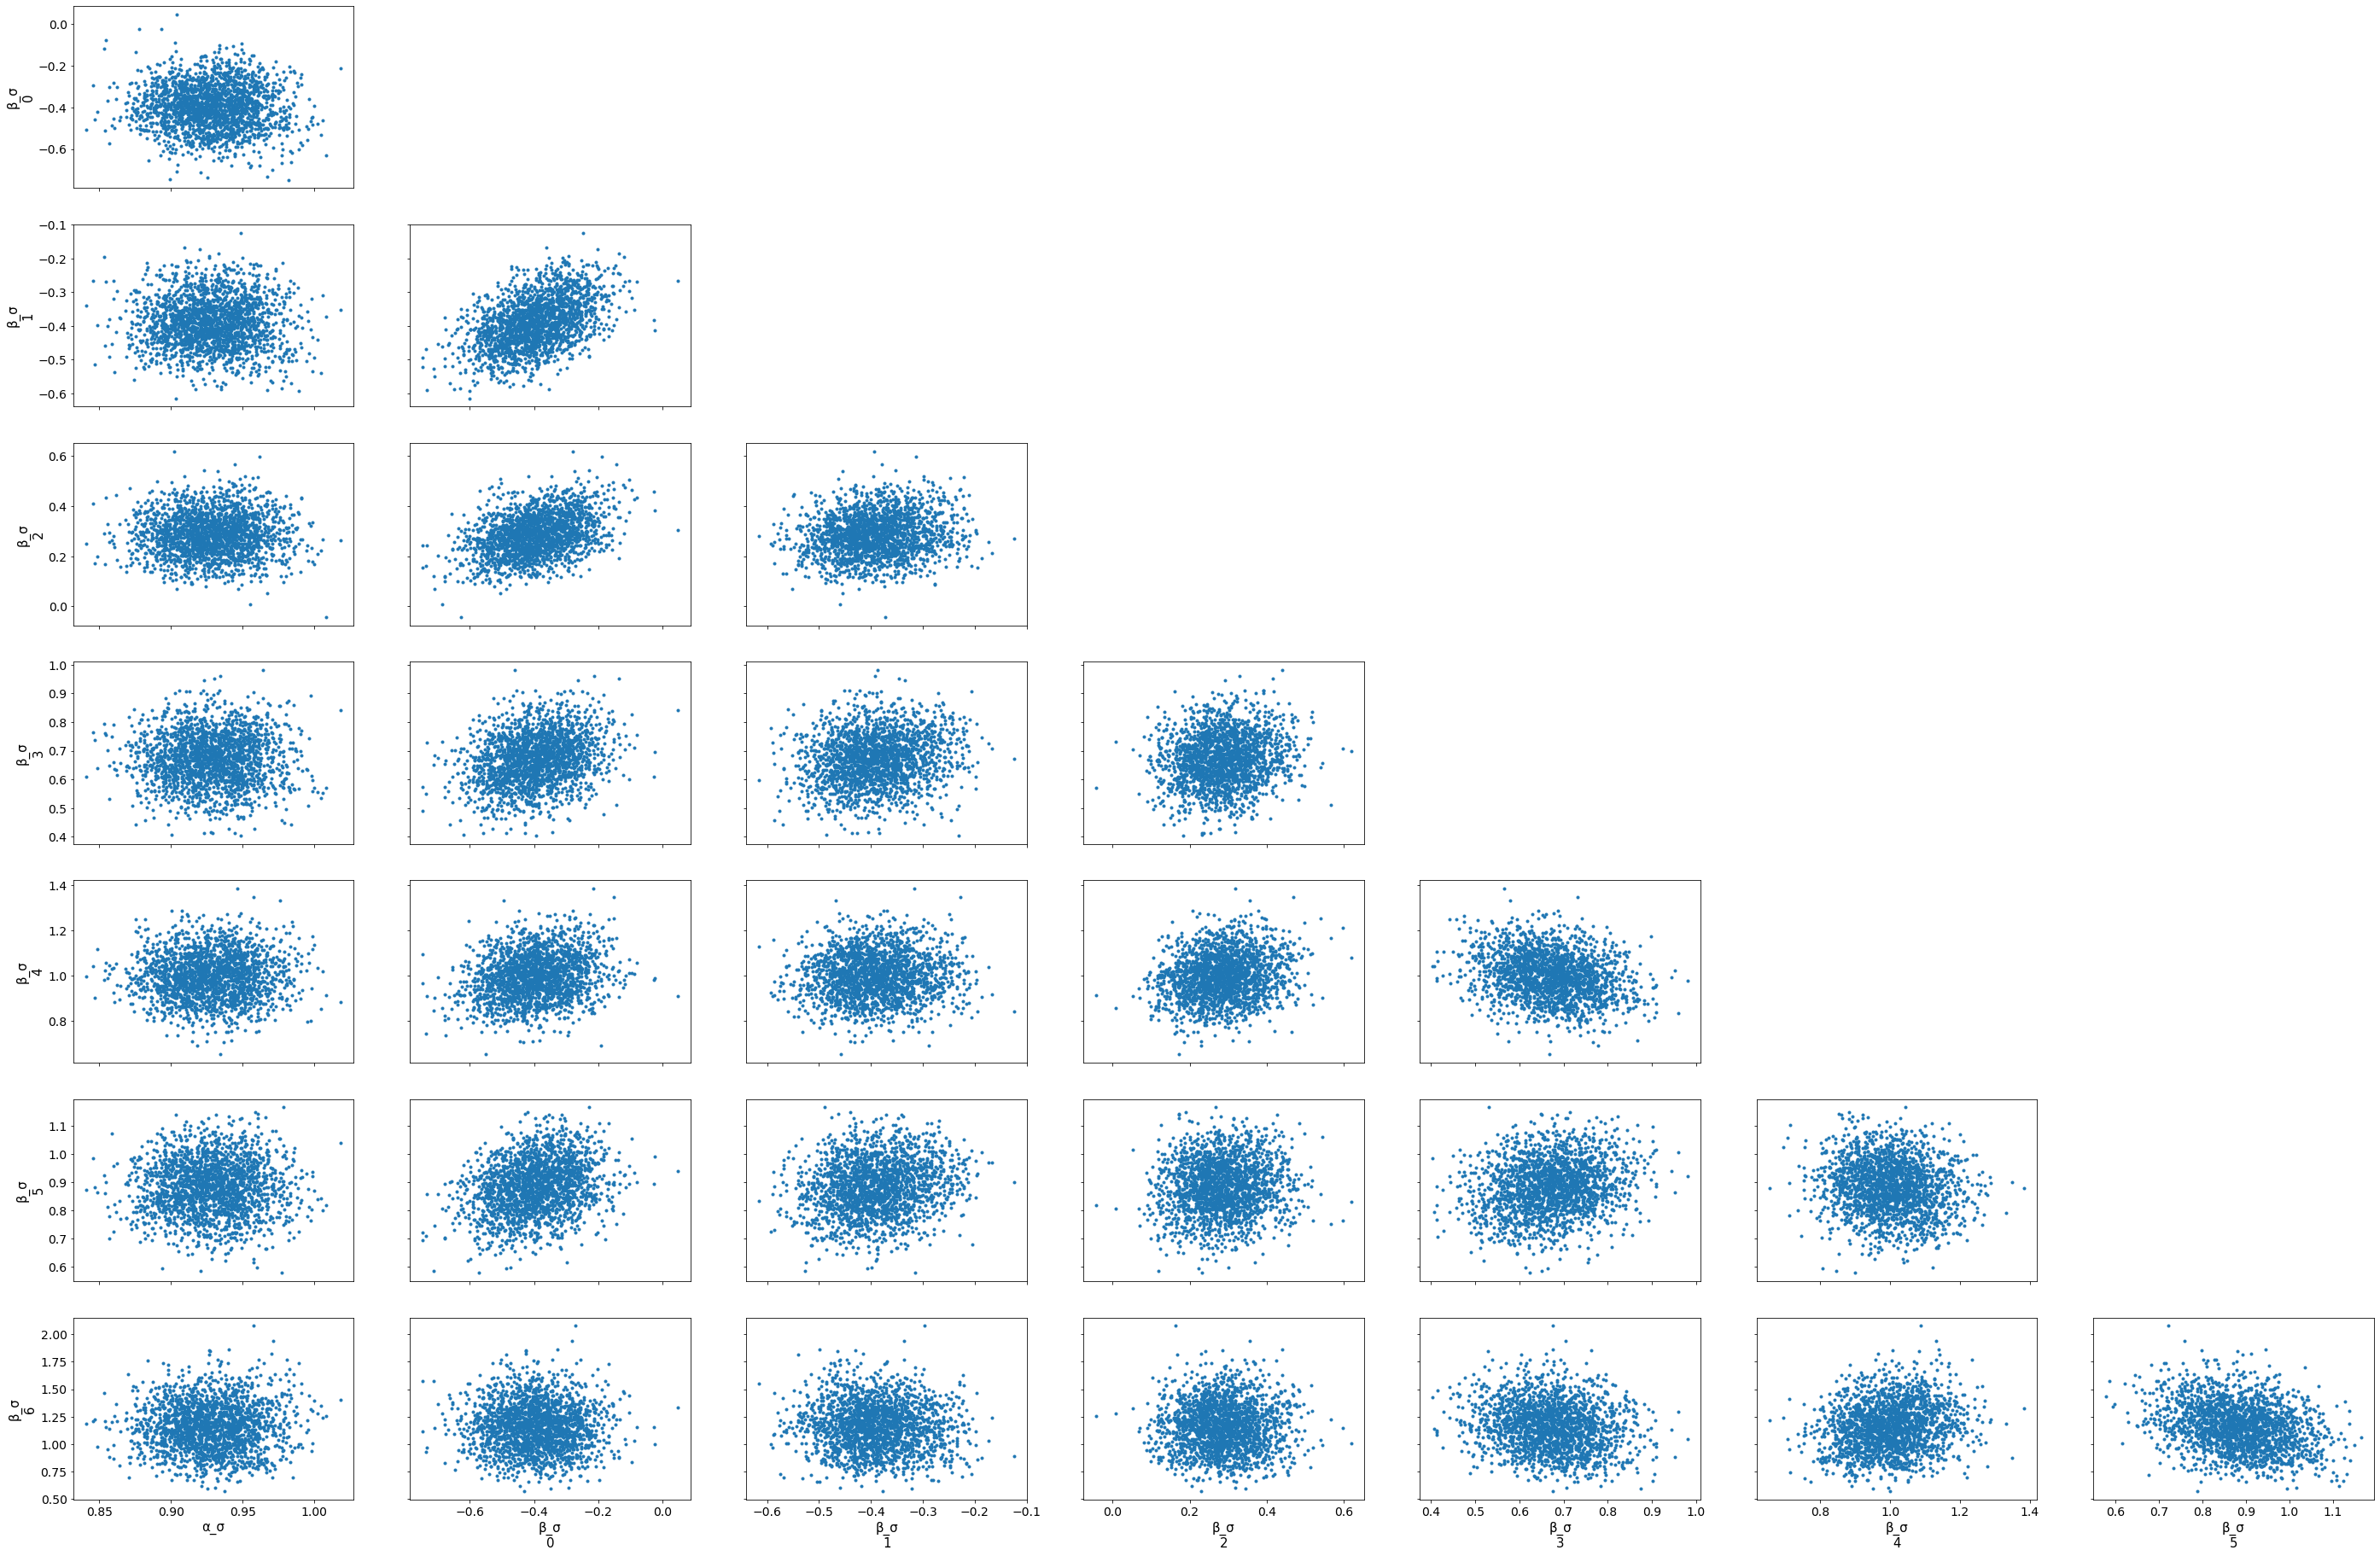

In [72]:
az.plot_pair(idata, var_names=["α_σ", "β_σ"]);

TODO

* Use Gaussian random walk prior (GRW) 